In [113]:
import os
if not os.path.isfile("NOPIP"):
    print("Running pip installs. Create a file called 'NOPIP' to disable.")
    %pip install carbon-simulator
    %pip install ipywidgets
    %pip install openpyxl

from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params, PathInterpolation as PI
from carbon.helpers import require_version
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
try:
    from simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    from carbon.helpers.simulation import __VERSION__ as csimversion
    print(f"Using local copy of the simulation library [v{simversion}; Carbon: v{csimversion}]")
except:
    from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    print(f"Using simulation library in Carbon [v{simversion}]")
try:
    from strategym import strategy, __VERSION__ as stratversion
    from carbon.helpers.strategym import __VERSION__ as cstratversion
    print(f"Using local copy of the strategy library [v{stratversion}; Carbon: v{cstratversion}]")
except:
    from carbon.helpers.strategym import strategy, __VERSION__ as stratversion
    print(f"Using strategy library in Carbon [v{stratversion}]")

import math
from IPython.display import HTML

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.3")

Using local copy of the simulation library [v3.3.2; Carbon: v3.3.1]
Using local copy of the strategy library [v2.6.1; Carbon: v2.6.1]
Carbon v2.3.1 (31/Jan/2022)


# Carbon Simulation - Scenarios

## Chart elements and look

In [114]:
colors = dict()
colors["darkmode"] = {
    'bidFill': 'lightgreen',
    'askFill': 'lightcoral',
    'bid': 'green',
    'ask': 'red',
    'price': 'darkorange',
    'value0': 'mediumblue',
    'hodl': 'cyan',
    'value': ('blue', 'silver'),
    'valuehf': ('royalblue', 'silver')
}
colors["lightmode"] = {
    'bidFill': 'lightgreen',
    'askFill': 'lightcoral',
    'bid': 'green',
    'ask': 'red',
    'price': 'darkorange',
    'value0': 'lightblue',
    'hodl': 'cyan',
    'value': ('blue', 'silver'),
    'valuehf': ('royalblue', 'silver')
}
# -

In [115]:
sim_defaults = {
    'plotPrice': True,
    'plotValueCsh': True,
    'plotValueRsk': False,
    'plotValueTotal': True,
    'plotValueHODL': False,
    'plotValue0': True,
    'plotRanges': True,
    'plotMargP': True,
    'plotBid': True,
    'plotAsk': True,
    'plotInterpolated': True,
    "plotDark": False,
    'plotValueGrey': False,
}
plt_styles = (('seaborn-v0_8-dark', 'seaborn-dark'), ('dark_background',)*2)

In [116]:
try: 
    params_w()
except:
    params_w = CheckboxManager.from_idvdct(sim_defaults)
    params_w()

## Scenario selection

In [117]:
DATAPATH = "../data"
fname = lambda data, col: f"{datetime.datetime.now().strftime('%m%d-%H%M%S')}-{data}-{col.replace('/', '')}.png"
SCENARIOPATH, EXT = "./scenarios", ".xlsx" # possible extensions: xlsx and csv
scfn = lambda fid: f"{SCENARIOPATH}/{fid}{EXT}"
try:
    scenariofn_w()
except:
    scenariofn_w = DropdownManager(listdir(SCENARIOPATH, EXT))
    scenariofn_w()

Dropdown(options=(('000_ScenariosDemo', '000_ScenariosDemo'), ('~$000_ScenariosDemo', '~$000_ScenariosDemo')),…

In [118]:
pread = pd.read_excel if EXT == ".xlsx" else pd.read_csv
scenario_df = pread(scfn(scenariofn_w.value)).set_index("scid")
cols = tuple({k:None for k in scenario_df["scgroup"]})
try:
    assert scenariofn_w.value == old_scenariofn_w_value
    assert cols == old_cols
    datacols_w()
except:
    old_scenariofn_w_value = scenariofn_w.value
    old_cols=cols
    datacols_w = DropdownManager(cols)
    datacols_w()

Dropdown(index=3, options=(('Intro', 'Intro'), ('Explainer (cycles)', 'Explainer (cycles)'), ('Explainer (gap …

In [119]:
HTML(f"<h2>Charts `{datacols_w.value}`</h2>")


Scenario 'Explainer (hf/lf) - 1':
TVL0=1000.0, TVL1=6873.8 (587.4%; h=35.1%)
(low frequency data)


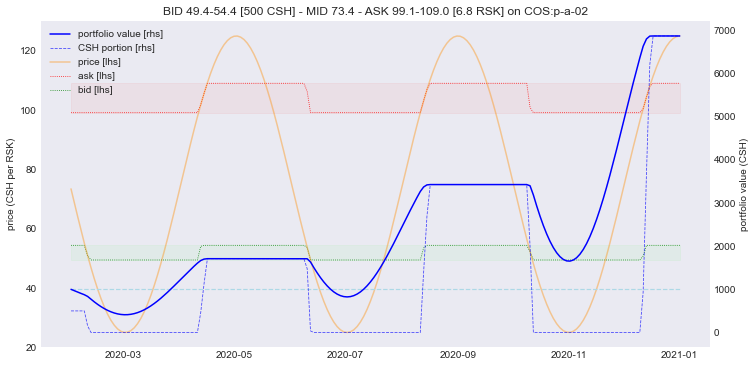


Scenario 'Explainer (hf/lf) - 2':
TVL0=1000.0, TVL1=6873.8 (587.4%; h=35.1%), TVL1_lf=6873.8 (587.4%; h=35.1%)
(both lf and (generated) hf)


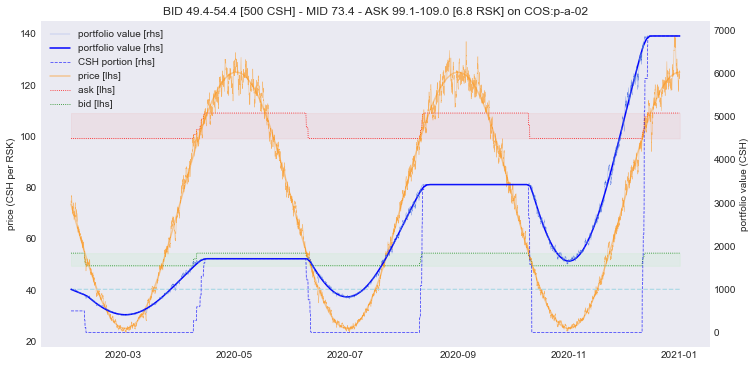


Scenario 'Explainer (hf/lf) - 3':
TVL0=1000.0, TVL1=6873.8 (587.4%; h=35.1%)
(only (generated) hf)


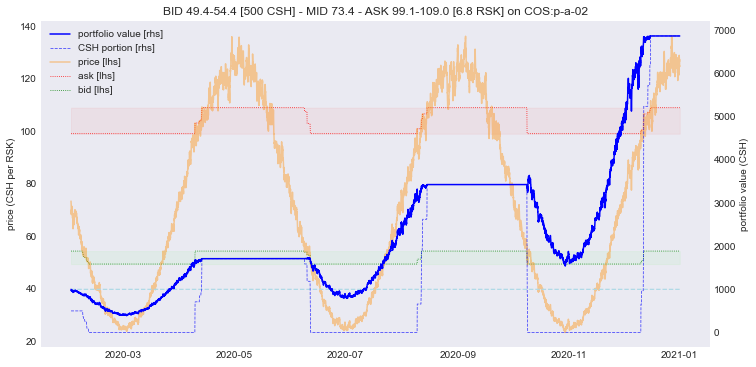

In [120]:
def filter_isnan(val):
    """returns val unless val=nan, then it returns ''"""
    try:
        if math.isnan(val):
            return ""
    except TypeError:
        return val
    
df_select = scenario_df[scenario_df["scgroup"]==datacols_w.value]
_ = plt_style(*plt_styles[1]) if params_w.values_dct["plotDark"] else plt_style(*plt_styles[0])
for sc, r in df_select.to_dict(orient="index").items():
    STARTPC, LENPC       = r["data_startpc"], r["data_lenpc"]
    DATAID, COLNM        = r["data_id"], r["data_col"]
    INVERT, INTERPOLATE  = r["data_invert"], r["data_interpolate"]
    ONLY_HF              = r["data_onlyhf"]
    PIPERIOD, PIFACTOR   = PI.hours(r["data_piperiod"]), r["data_pifactor"]
    PATH_MIN_DATE        = r["data_pathmindt"]
    TVL, CASHPC          = r["strat_tvl"], r["strat_cashpc"]
    COMMENT              = filter_isnan(r["comment"]) 
    DATAFN               = f'{DATAPATH}/{DATAID}.pickle'
    strats               = { sc: [strategy.from_dct(r)] }
    path0, pair = pdread(DATAFN, COLNM, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE, invert=INVERT, tkns=True)
    path = PI.interpolate(path0, PIPERIOD, sigfctr=PIFACTOR, enable=INTERPOLATE)
    path0 = path if ONLY_HF else path0
    for ix, stratid in enumerate(strats):
        strat = [s.set_tvl(spot=path0[0], cashpc=CASHPC, tvl=TVL) for s in strats[stratid]]
        simresults  = run_sim(strat, path)
        simresults0 = run_sim(strat, path0) if not path is path0 else simresults
        v0, v1, v1a,  = simresults.value_r[0], simresults.value_r[-1], simresults0.value_r[-1]
        vh1, vh1a = simresults.hodl_r[-1], simresults0.hodl_r[-1]
        tvl1 = f"TVL1={v1:.1f} ({v1/v0*100-100:.1f}%; h={vh1/v0*100-100:.1f}%)"
        if not path is path0:
            tvl1 = f"{tvl1}, TVL1_lf={v1a:.1f} ({v1a/v0*100-100:.1f}%; h={vh1a/v0*100-100:.1f}%)"
        print(f"\nScenario '{stratid}':\nTVL0={v0:.1f}, {tvl1}")
        if (COMMENT): print(f"({COMMENT})")
        plot_sim(simresults, simresults0, f"{DATAID}:{COLNM}", Params(**params_w.values_dct), pair=pair, colors=colors)
        plt.show()
# -

In [121]:
# r = {
#     "scid": "sc1",
#     "data_id": 'COINS-ETH',
#     "data_col": 'BTC/ETH',
#     "data_startpc": 0.,
#     "data_lenpc": 1.0,
#     "data_pathmindt": '2021-01-01',
#     "data_invert": False,
#     "data_interpolate": False,
#     "data_piperiod": 1.,
#     "data_pifactor": 1.,
#     "strat_tp": "mgw",
#     "strat_m": 100,
#     "strat_g": 0.1,
#     "strat_wbuy": 0.1,
#     "strat_wsell": 0.1,
#     "strat_ubuy": 0,
#     "strat_usell": 0,
#     "strat_cashpc": 0.5,
#     "strat_tvl": 1000,
# }
# df = pd.DataFrame.from_records([r]).set_index("scid")
# df.to_csv(scfn("bla0"))
# df
# raise

HTML(f"<h2>Description `{datacols_w.value}`</h2>")

In [122]:
# NOTE: those functions will be available in carbon.helpers from v2.3.2
rr = df_select.to_dict(orient="index")

def r0(rr):
    return rr[tuple(rr)[0]]

def dr(r, r0, purge=True):
    result = {k: r[k] if r[k] != r0[k] else None for k in r0}
    if not purge: return result
    return {k:v for k,v in result.items() if not v is None and not k in ["id0", "comment"]}

def drr(rr, baseline=False, purge=True, asdf=False, comment=True):
    r0k = tuple(rr)[0]
    r0 = rr[r0k]
    if not asdf:
        result = {k:dr(r, r0, purge) for k,r in rr.items()}
        if not baseline:
            return result
        result[r0k] = {k:v for k,v in r0.items() if not k in ["id0", "comment"]}
        return result
    else:
        result = {k:dr(r, r0, purge=False) for k,r in rr.items()}
        df = pd.DataFrame.from_records(result).T.fillna("")
        del df["id0"]
        if not comment: 
            del df["comment"]
        df = df[ [col for col in df.columns  if (df[col]!= "").any()] ]                
        return df

r0(rr)

{'scgroup': 'Explainer (hf/lf)',
 'id0': 1,
 'data_id': 'COS',
 'data_col': 'p-a-02',
 'data_invert': False,
 'data_interpolate': False,
 'data_onlyhf': False,
 'data_piperiod': 1,
 'data_pifactor': 1.5,
 'data_startpc': 0.08333333333333333,
 'data_lenpc': 1,
 'data_pathmindt': '2020-01-01',
 'strat_type': 'mgw',
 'strat_m': 100,
 'strat_g': 0.7,
 'strat_wbuy': 0.1,
 'strat_wsell': 0.1,
 'strat_ubuy': 0,
 'strat_usell': 0,
 'strat_cashpc': 0.5,
 'strat_tvl': 1000,
 'comment': 'low frequency data'}

In [123]:
drr(rr)

{'Explainer (hf/lf) - 1': {},
 'Explainer (hf/lf) - 2': {'data_interpolate': True},
 'Explainer (hf/lf) - 3': {'data_interpolate': True, 'data_onlyhf': True}}

In [124]:
drr(rr, asdf=True, baseline=False, comment=True)

,data_interpolate,data_onlyhf,comment
Explainer (hf/lf) - 1,,,
Explainer (hf/lf) - 2,True,,both lf and (generated) hf
Explainer (hf/lf) - 3,True,True,only (generated) hf
